# XGB user-based recommender with RFM

Содержание:
1. [Описание подхода](#desk)
2. [Требования](#rec)
3. [Подготовка данных](#data-prep)
4. [Обучение модели](#model)

### Описание подхода <a class="anchor" id="desk"></a>

Подход основан на дополнении информации из контекста к скорам бейзлайна с помощью градиентного бустинга.

На вход градиентному бустингу подаются следующие предикторы:

- Вектор наличия товара в истории (длина вектора - кол-во всех товаров в ассортименте)
- Вектор наличия товара в корзине
- Временные предикторы
- Атрибуты клиента (пол, возраст)
- Атрибуты товара в таргете
- Скор от SVD

Скор от SVD рассчитывается, как косинусная близость эмбеддинга товара в таргете и суммы эмбеддингов товаров в корзине.

На отложенной выборке скор ~ 0.33

### Требования <a class="anchor" id="rec"></a>

Для воспроизведения результатов нужны следующие датасеты:

- /data/processed/rfm_client_hist_context_target_product.csv - для обучения XGB (строка - один клиент)

- /data/processed/purchases.csv - для обучения SVD (строка - товар, транзакция)

- /data/processed/products.csv - для скоринга товаров на валидации

### Подготовка данных <a class="anchor" id="data-prep"></a>


In [8]:
import sys
import os
import functools as ft
root = ft.reduce(os.path.join, ['..'])

import pandas as pd
import numpy as np
import scipy
import xgboost as xgb
import torch
import pickle

from sklearn.metrics.pairwise import cosine_similarity

# Сохранение состояния моделей
SAVE_SATE = True

# Товары для скоринга
products = pd.read_csv(ft.reduce(os.path.join, [root, 'data', 'processed', 'products.csv']), index_col=0)
products = products.sort_index()

PRODUCTS_COUNT = products.shape[0]

products['target_product'] = range(PRODUCTS_COUNT) 

X_train = pd.read_csv(ft.reduce(os.path.join, [root, 'data', 'processed', 'rfm_client_hist_context_target_product.csv']), index_col=0)
# Выбираем только клиентов с историей
X_train = X_train.drop(['is_new_client'], axis=1)

# Загрузка датасета со всеми транзакциями. Датасет вида: время-транзакция-товар
path = ft.reduce(os.path.join, [root,'data', 'processed', 'purchases.csv'])
df = pd.read_csv(path, dtype={'transaction_idx': str, 'product_idx': int})
df = df[['transaction_datetime', 'client_idx', 'transaction_idx', 'product_idx']]


#Датасеты для SVD и XGB имеют разные форматы, поэтому разделяем их по времени.
split_date = '2019-03-12 15:00:00' 
train_transactions = df[df.transaction_datetime < split_date]
del df

scores=[]
time_distr = []
num_fold = int(X_train.shape[0]/5)


bask = ['b_' + str(x) for x in range(PRODUCTS_COUNT)]

### Обучение модели <a class="anchor" id="model"></a>

In [9]:
def gpu_validate(test_slice):
    """Функция валидации тестового датасета. Расчет косинусной близости реализован на pytorch.
    Итерация происходит по каждому клиенту в тестовом датасете. 
    В ходе итерации собирается батч вида клиент-товар, где атрибуты клиента фиксированны, 
    а изменяется только товар в таргете и его атрибуты."""
    
    target_input = test_slice['target_product'].values
    test_input = []

    for index, user in test_slice.drop(products.columns, axis=1).iterrows():

        # Текущая корзина клиента
        basket = user['b_0':'b_199']

        # Собираем батч клиент-товар
        user_df = pd.concat([user] * PRODUCTS_COUNT, axis=1).transpose().drop('target', axis=1)
        user_df = pd.concat([user_df.reset_index(drop=True), products], axis=1)
        
        # Считаем скор SVD на gpu, если доступна видеокарта
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        a = torch.from_numpy(svd_model.X_train_svd).to(device)
        b = torch.from_numpy(svd_model.X_train_svd[basket.values.astype(bool)].sum(0).reshape(1, -1)).to(device)
        a_norm = a / a.norm(dim=1)[:, None]
        b_norm = b / b.norm(dim=1)[:, None]
        res = torch.mm(a_norm, b_norm.transpose(0,1)).cpu().numpy()

        user_df['knn_score'] = res
        user_df = user_df[dataset_columns]

        y_pred = xgb_model.predict(user_df.values)

        # Ранжируем товары, исключаем товары из корзины
        y_pred[basket.values.astype(bool)] = -np.inf
        preds = np.argpartition(y_pred, -3, axis=0)[-3:]
        test_input.append(list(preds))

    return (target_input, test_input)


### Метрика

In [10]:
def precision(true, pred):
    if true in pred:
        return 1
    else:
        return 0

def mean_precision(true, pred):
    sum_ = 0
    for t, p in zip(true, pred):
        sum_ += precision(t, p)
    return sum_ / len(true)

### SVD модель

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.decomposition import TruncatedSVD

class RecommenderSVDKNN:
    def __init__(self, emb_dim=500, num_neighb=30, metric='cosine'):
        self.params = {'embedding_dim': emb_dim,
                       'num_neighbours': num_neighb,
                       'metric': metric}
        self.svd = TruncatedSVD(self.params['embedding_dim'])


    def fit(self, x_train_sparse):
        self.X_train_svd = self.svd.fit_transform(x_train_sparse)
    
    def argpartition(self, row, num):
        row_sim, row_y = row
        mask = np.zeros(len(row_sim), bool)
        mask[row_y] = 1
        sim_temp = row_sim.copy()
        sim_temp[mask] = -float('inf')

        return np.argpartition(sim_temp, -num, axis=0)[-num:]
    
    def predict_sample(self, x_test_row, num=3):
        r = np.array(x_test_row)
        sim = cosine_similarity(self.X_train_svd, 
                                self.X_train_svd[r].sum(0).reshape((1, -1)))
        
        return self.argpartition((sim, r), num)
    

### Кросс-валидация

In [12]:
# Time cross-validation
# В последний фолд попадает отложенная выборка, состояние моделей записывается в /models/pkl/.
for fold in [3]:#range(4):
    
    # Разбиваем на обучение и тестирование. 
    train = X_train.iloc[0:(fold+1)*num_fold].copy()
    test = X_train.iloc[(fold+1)*num_fold+1:(fold+2)*num_fold].copy()

    print("start train svd")
    
    # Для SVD используем все транзакции клиентов, которые (клиенты) участвуют в обучении XGB
    train_svd = train_transactions[train_transactions.client_idx.isin(train.index.values)]
    
    # Формирование разряженной матрицы товар-чек
    rows = train_svd.transaction_idx.astype(int)
    cols = train_svd.product_idx.astype(int)
    sp_train = scipy.sparse.coo_matrix((np.ones_like(rows), (rows, cols)))
    sp_train = sp_train.toarray() / sp_train.sum(axis=0)
    svd_model = RecommenderSVDKNN(emb_dim=500)
    svd_model.fit(sp_train.T)
    
    # Подсчет скора от SVD
    train['knn_score'] = train.apply(lambda x: cosine_similarity(svd_model.X_train_svd[x.target_product].reshape(1, -1), svd_model.X_train_svd[x[bask].values.astype(bool)].sum(0).reshape(1, -1))[0][0], axis=1)
    
    # Перемешиваем выборку для обучения
    train = train.sample(frac=1)

    print("start train xgb")
    
    xgb_model = xgb.XGBRegressor(objective="reg:logistic", 
                                 #tree_method='gpu_hist', 
                                 #gpu_id=0, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 max_depth=6, 
                                 n_estimators=300)
    
    xgb_model.fit(train.drop('target', axis=1).values, train.target.values)
    
    print("start test")

    # На тесте испоьзуем только положительный таргет
    test = test[test.target == 1]
    # Сохраняем товары из таргета для расчета метрики
    target_input = test['target_product'].values
    # Массив для предикта
    test_input = []
    # Сохраняем порядок предикторов для XGB
    dataset_columns = train.drop('target', axis=1).columns  
    
    result = gpu_validate(test)
    
    score = mean_precision(result[0], result[1])
    print('Mean Precision:', score)
    scores.append(score)

if(SAVE_SATE == True):   

    # Сохранение состояния SVD
    svd_path = ft.reduce(os.path.join, [root, 'models', 'pkl', 'svd_model'+'.pkl'])    
    with open(svd_path, 'wb') as handle:
        pickle.dump(svd_model, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Сохранение состояния XGB
    xgb_path = ft.reduce(os.path.join, [root, 'models', 'pkl', 'xgb_model'+'.pkl'])
    with open(xgb_path, 'wb') as handle:
        pickle.dump(xgb_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

start train svd
start train xgb
start test
Mean Precision: 0.31291254125412543


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: handle
  warnings.warn(message)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

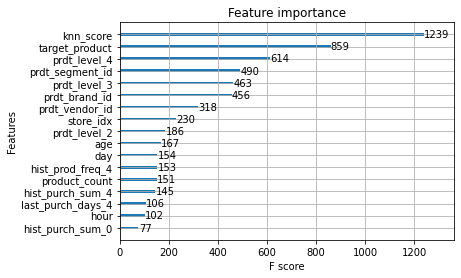

In [13]:
xgb_model.get_booster().feature_names = list(dataset_columns.values)
d_2 = xgb_model.get_booster().get_score(importance_type='weight')
xgb.plot_importance({k: v for k, v in d_2.items() if v > 70 })